In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import joblib

In [2]:
df=pd.read_csv('cardio_train.csv', sep=';')

In [3]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
#splitting the data into features and target 
X = df.drop(['cardio','id'], axis=1)
y = df['cardio']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
print(type(X_train), type(y_train), type(X_test), type(y_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


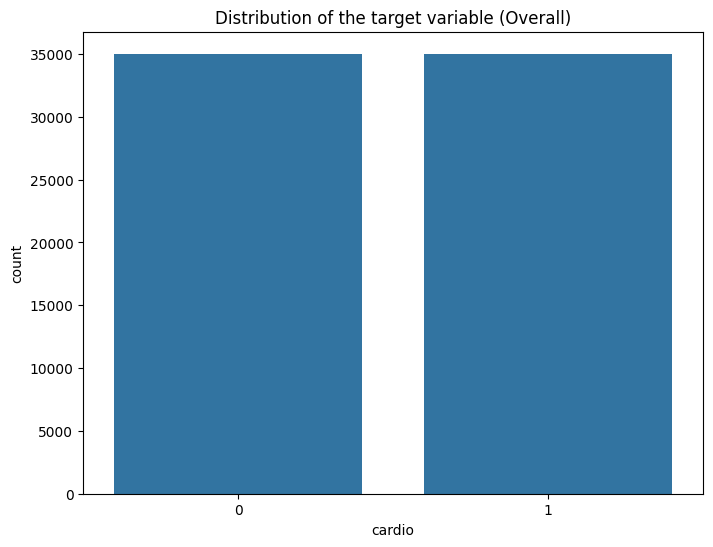

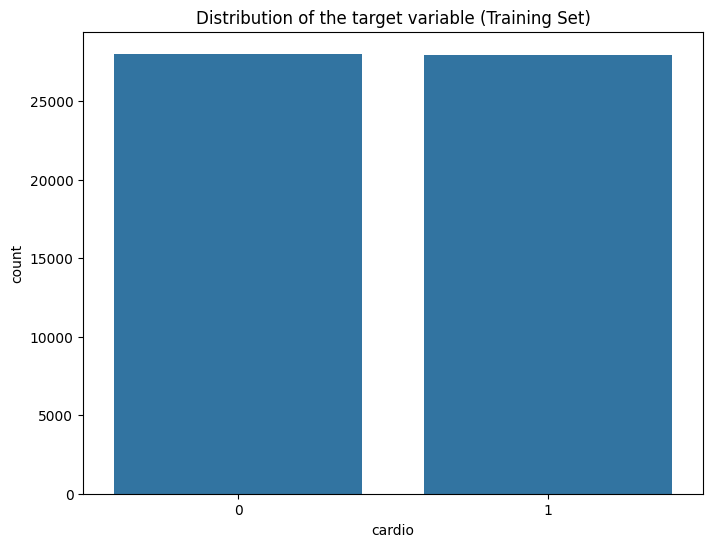

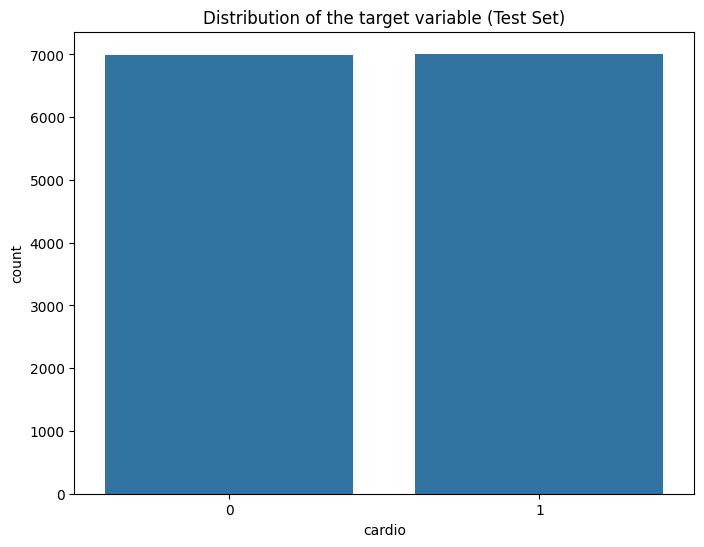

Overall target distribution:
 cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64
Training set target distribution:
 cardio
0    0.500589
1    0.499411
Name: proportion, dtype: float64
Test set target distribution:
 cardio
1    0.500857
0    0.499143
Name: proportion, dtype: float64


In [9]:
# Plot overall target distribution (y is a Series)
plt.figure(figsize=(8,6))
sns.countplot(x=y)  # Series can be passed directly
plt.title('Distribution of the target variable (Overall)')
plt.show()

# Plot training set target distribution (y_train is a Series)
plt.figure(figsize=(8,6))
sns.countplot(x=y_train)  # just pass the Series, no data= needed
plt.title('Distribution of the target variable (Training Set)')
plt.show()

# Plot test set target distribution (y_test is a Series)
plt.figure(figsize=(8,6))
sns.countplot(x=y_test)  # Series again
plt.title('Distribution of the target variable (Test Set)')
plt.show()

# Print normalized value counts for comparison
print("Overall target distribution:\n", y.value_counts(normalize=True))
print("Training set target distribution:\n", y_train.value_counts(normalize=True))
print("Test set target distribution:\n", y_test.value_counts(normalize=True))


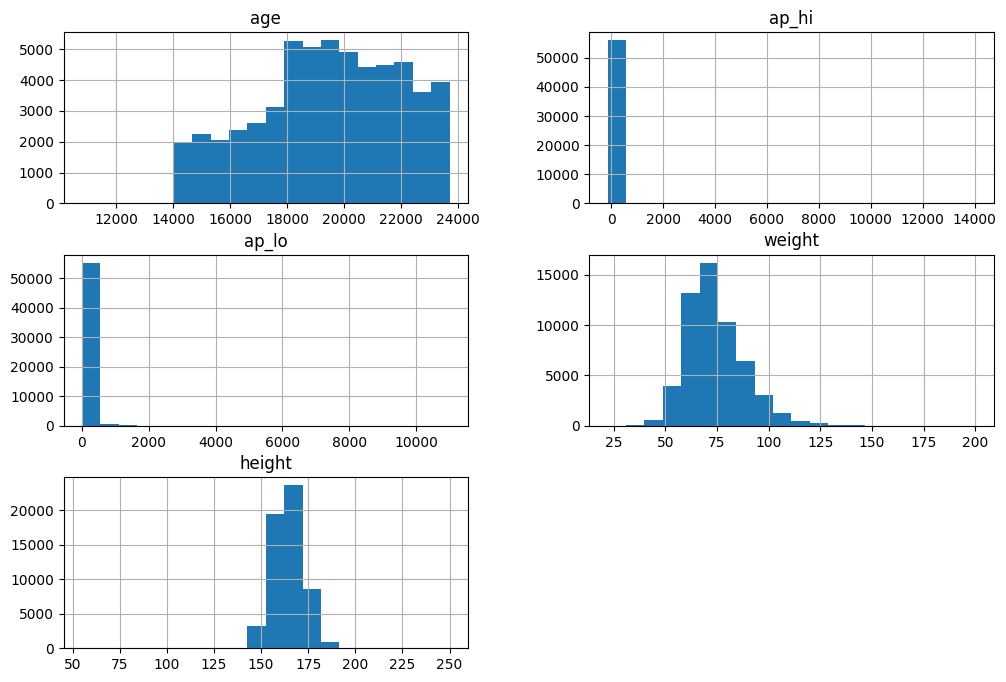

In [10]:
# Histograms for numerical features
numerical_features = ['age', 'ap_hi', 'ap_lo', 'weight', 'height']
X_train[numerical_features].hist(bins=20, figsize=(12,8))
plt.show()

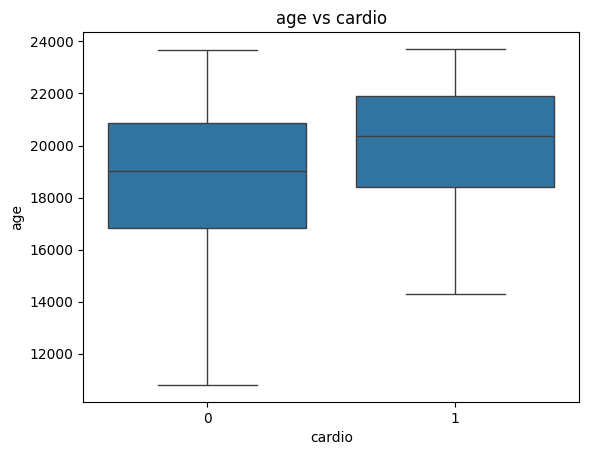

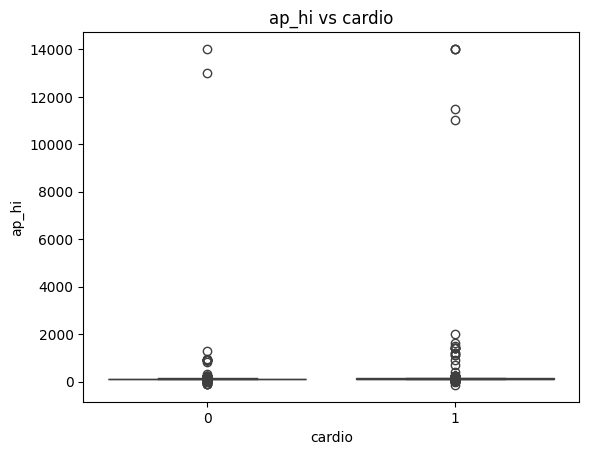

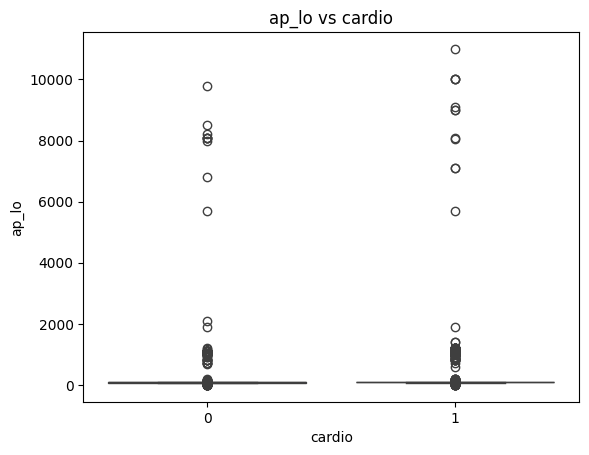

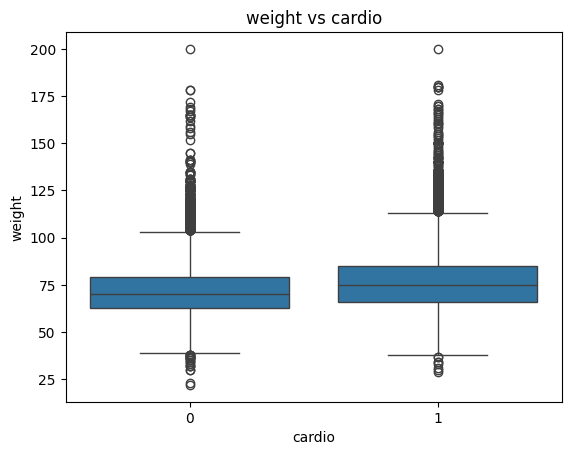

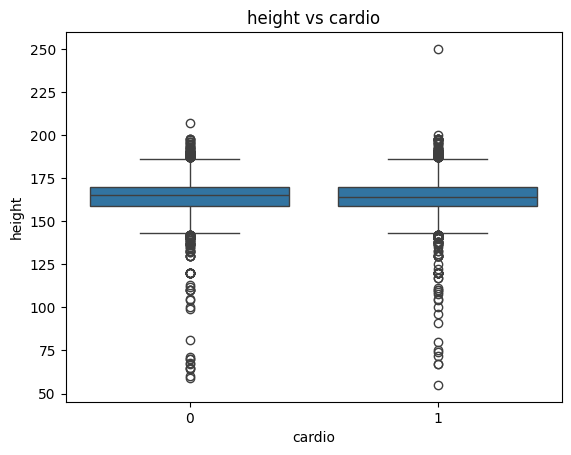

In [11]:
for col in numerical_features:
    sns.boxplot(x=y_train, y=X_train[col])
    plt.title(f"{col} vs cardio")
    plt.show()


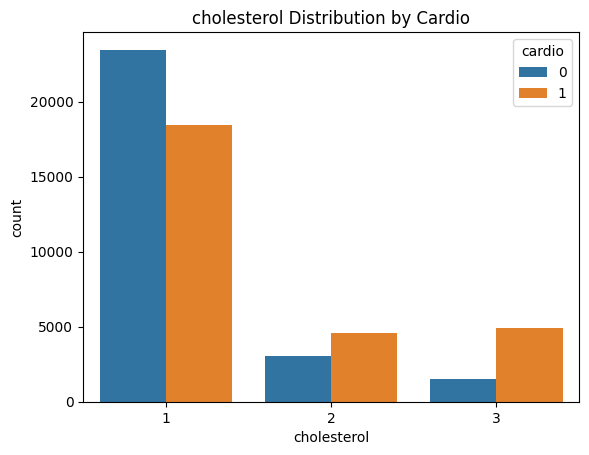

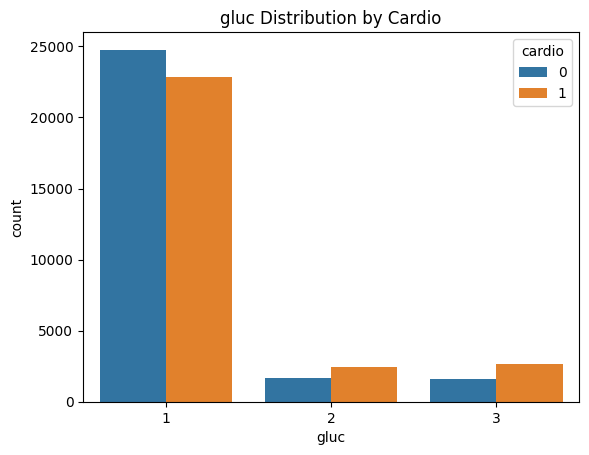

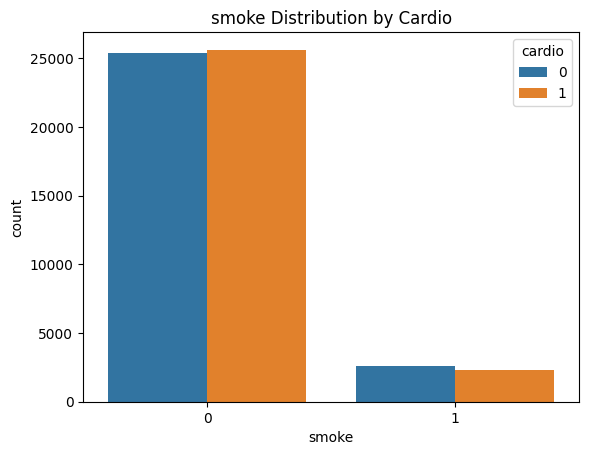

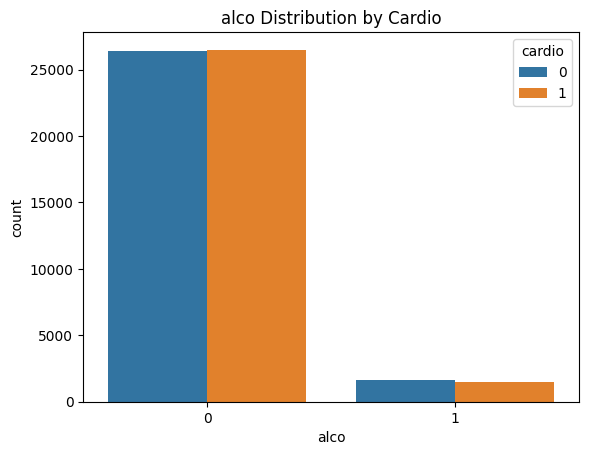

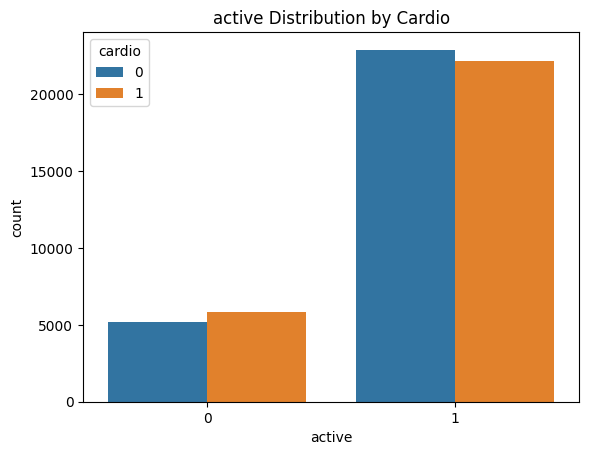

In [12]:
# Categorical features distribution
categorical_features = ['cholesterol','gluc','smoke','alco','active']
for col in categorical_features:
    sns.countplot(x=X_train[col], hue=y_train)
    plt.title(f"{col} Distribution by Cardio")
    plt.show()

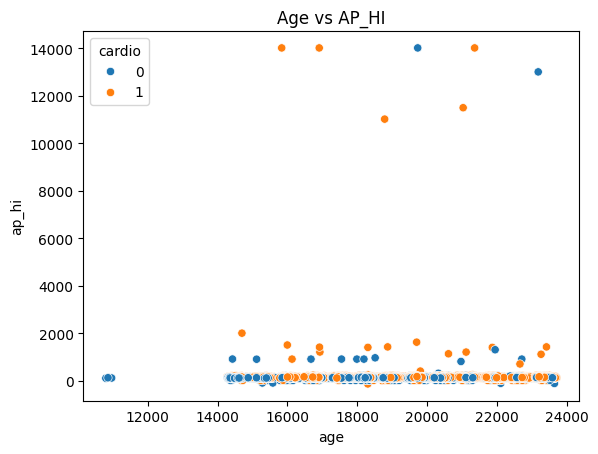

In [13]:
#  Feature relations
sns.scatterplot(x=X_train['age'], y=X_train['ap_hi'], hue=y_train)
plt.title("Age vs AP_HI")
plt.show()

In [27]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced_subsample',
    random_state=42


)
lr_model = LogisticRegression(
    max_iter=3000,
    C=10,
    penalty='l2',
    class_weight='balanced',
    solver='liblinear'
    
)
knn_model = KNeighborsClassifier(
    n_neighbors=15,
    weights='distance',
    metric='minkowski',
    p=2
)
svc_model = SVC(
   kernel='rbf',
C=5.0,
gamma=0.01,
class_weight='balanced',
probability=True


)
xg_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_weight=3,
    eval_metric='logloss',
    tree_method='hist'
)


In [16]:
results = {}
best_f1 = 0
best_model_name = ""


In [17]:
# Logistic Regression
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]  # for ROC-AUC

results["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "F1": f1_score(y_test, y_pred_lr),
    "ROC-AUC": roc_auc_score(y_test, y_pred_prob_lr)
}

print("=== Logistic Regression ===")
print("Predictions (first 20):", y_pred_lr[:20])
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("="*50)

=== Logistic Regression ===
Predictions (first 20): [1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0]
Accuracy: 0.7102142857142857
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72      6988
           1       0.73      0.68      0.70      7012

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000

Confusion Matrix:
 [[5200 1788]
 [2269 4743]]


In [18]:
# Random Forest
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

results["Random Forest"] = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC-AUC": roc_auc_score(y_test, y_pred_prob_rf)
}


print("=== Random Forest ===")
print("Predictions (first 20):", y_pred_rf[:20])
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("="*50)

=== Random Forest ===
Predictions (first 20): [1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0]
Accuracy: 0.736
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.75      6988
           1       0.76      0.70      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000

Confusion Matrix:
 [[5408 1580]
 [2116 4896]]


In [ ]:
# XGBoost
xg_model.fit(X_train, y_train)
y_pred_xg = xg_model.predict(X_test)
y_pred_prob_xg = xg_model.predict_proba(X_test)[:, 1]

results["XGBoost"] = {
    "Accuracy": accuracy_score(y_test, y_pred_xg),
    "F1": f1_score(y_test, y_pred_xg),
    "ROC-AUC": roc_auc_score(y_test, y_pred_prob_xg)
} 

print("=== XGBoost ===")
print("Predictions (first 20):", y_pred_xg[:20])
print("Accuracy:", accuracy_score(y_test, y_pred_xg))
print("Classification Report:\n", classification_report(y_test, y_pred_xg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xg))
print("="*50)

=== XGBoost ===
Predictions (first 20): [1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0]
Accuracy: 0.7389285714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75      6988
           1       0.76      0.70      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000

Confusion Matrix:
 [[5440 1548]
 [2107 4905]]


In [20]:
# KNN
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
y_pred_prob_knn = knn_model.predict_proba(X_test)[:, 1]

results["KNN"] = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "F1": f1_score(y_test, y_pred_knn),
    "ROC-AUC": roc_auc_score(y_test, y_pred_prob_knn)
}

print("=== KNN ===")
print("Predictions (first 20):", y_pred_knn[:20])
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("="*50)

=== KNN ===
Predictions (first 20): [1 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0]
Accuracy: 0.7077857142857142
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.74      0.72      6988
           1       0.72      0.67      0.70      7012

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000

Confusion Matrix:
 [[5177 1811]
 [2280 4732]]


In [ ]:
# SVC
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
y_pred_prob_svc = svc_model.predict_proba(X_test)[:, 1]

results["SVC"] = {
    "Accuracy": accuracy_score(y_test, y_pred_svc),
    "F1": f1_score(y_test, y_pred_svc),
    "ROC-AUC": roc_auc_score(y_test, y_pred_prob_svc)
}

print("=== SVC ===")
print("Predictions (first 20):", y_pred_svc[:20])
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Classification Report:\n", classification_report(y_test, y_pred_svc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))
print("="*50)


In [25]:
'''
ROC-AUC tells you how good your model is at ranking patients 
from most likely to least likely to have heart disease.

Example:
AUC = 0.9 → 9 out of 10 times, your model correctly ranks sick higher than healthy.
AUC = 0.5 → your model is guessing randomly.
'''

for name, metrics in results.items():
    if metrics["F1"] > best_f1:
        best_f1 = metrics["F1"]
        best_model_name = name

print(f"\nBest model by F1-score: {best_model_name} (F1 = {best_f1:.4f})")




Best model by F1-score: XGBoost (F1 = 0.7286)


In [ ]:
import xgboost as xgb

# --- Save model ---
xg_model.save_model("xg_model.json")   

# --- Load model ---
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_model.json")

# sample Test prediction
print(loaded_model.predict(X_test[:5]))


[1 1 1 0 0]


In [31]:


# Train new model
xgb_model_modified = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model_modified.fit(X_train, y_train)

# Save as a new file
xgb_model_modified.save_model("xgb_model_modified.json")

# Load it later
loaded_model = XGBClassifier()
loaded_model.load_model("xgb_model_modified.json")
